# Bond Return estimation from Bond Yields


## Dependencies


### Packages


In [74]:
!pip install matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data

In [76]:
yields_df = pd.read_csv("Data/Bonds/Yields.csv", sep= ";", index_col=0)
yields_df = yields_df[[col for col in yields_df.columns if "Bid" in col]].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', '.').str.strip()))
display(yields_df)

,TS Bid 6luni,TS Bid 12 luni,TS Bid 3 ani,TS Bid 5 ani,TS Bid 10 ani
Data,,,,,
2025-08-07,6.90,7.01,7.29,7.43,7.29
2025-08-06,6.91,7.01,7.29,7.43,7.29
2025-08-05,6.91,6.99,7.28,7.44,7.28
2025-08-04,6.91,6.99,7.27,7.42,7.29
2025-08-01,6.89,6.97,7.27,7.42,7.27
...,...,...,...,...,...
2011-01-14,6.51,6.79,7.11,7.29,7.39
2011-01-13,6.58,6.83,7.17,7.26,7.38
2011-01-12,6.61,6.87,7.25,7.34,7.38


## Bond Return Estimation

Since we are faced with a lack of bond returns data, we will follow Cochrane's approach for estimating bond holding period returns from the bond yields across different maturities using the forward rate method. The approach decomposes bond returns into expected carry (short-term forward rates) and unexpected changes in the forward rate curve, offering insight into bond price dynamics. 

Cochrane defines the **log holding period return** on an \(n\)-period zero-coupon bond between times \(t\) and \(t+1\) as:

<br>

$$
r_{t+1}^{(n)} = f_t^{(0)} - \Delta f_{t+1}^{(n-1)}
$$



where:

- $f_t^{(0)}$ is the forward rate starting now (the short rate),
- $\Delta f_{t+1}^{(n-1)} = f_{t+1}^{(n-1)} - f_t^{(n)}$ is the change in the forward rate starting \(n-1\) periods ahead.

This decomposition shows that bond returns are driven by the short-term yield (carry) minus the unexpected change in future forward rates.


### Step 1: Convert yields to zero-coupon bond prices


Zero-coupon bond price for maturity \(n\) years at time \(t\):

$$
P_t^{(n)} = e^{-n \times y_t^{(n)}}
$$

where $y_t^{(n)}$ is the continuously compounded yield.

In [77]:
#define a dictionary for maturities
maturities = {
    "TS Bid 6luni":   0.5,
    "TS Bid 12 luni":   1,
    "TS Bid 3 ani":     3,
    "TS Bid 5 ani":     5,
    "TS Bid 10 ani":   10
}

price_df = pd.DataFrame(index=yields_df.index)

for col, t in maturities.items():
    price_df[col.replace('TS Bid ','P_').replace(' luni', 'm').replace('luni','m').replace(' ani', 'y')] = np.exp((-yields_df[col])/100 * t)

maturities = dict(zip(price_df.columns, maturities.values()))

display(price_df) 

,P_6m,P_12m,P_3y,P_5y,P_10y
Data,,,,,
2025-08-07,0.966088,0.932301,0.803563,0.689699,0.482391
2025-08-06,0.966040,0.932301,0.803563,0.689699,0.482391
2025-08-05,0.966040,0.932487,0.803804,0.689354,0.482874
2025-08-04,0.966040,0.932487,0.804045,0.690044,0.482391
2025-08-01,0.966137,0.932674,0.804045,0.690044,0.483357
...,...,...,...,...,...
2011-01-14,0.967974,0.934354,0.807914,0.694544,0.477591
2011-01-13,0.967635,0.933980,0.806461,0.695586,0.478069
2011-01-12,0.967490,0.933607,0.804528,0.692810,0.478069


### Step 2: Compute forward rates

The forward rate between maturities $T_1$ and $T_2$ at time $t$ is given by:

$$
f_t(T_1, T_2) = \frac{\ln P_t(T_1) - \ln P_t(T_2)}{T_2 - T_1}
$$

In [78]:
forward_rates = pd.DataFrame(index=price_df.index)
maturity_cols = list(maturities.keys())

for i in range(len(maturity_cols) - 1):
    T1, T2 = maturities[list(maturities.keys())[i]], maturities[list(maturities.keys())[i+1]]
    col_name = f"f_{maturity_cols[i]}_{maturity_cols[i+1]}"
    forward_rates[col_name] = (np.log(price_df[maturity_cols[i]]) - np.log(price_df[maturity_cols[i+1]])) / (T2 - T1)

display(forward_rates)

,f_P_6m_P_12m,f_P_12m_P_3y,f_P_3y_P_5y,f_P_5y_P_10y
Data,,,,
2025-08-07,0.0712,0.07430,0.07640,0.0715
2025-08-06,0.0711,0.07430,0.07640,0.0715
2025-08-05,0.0707,0.07425,0.07680,0.0712
2025-08-04,0.0707,0.07410,0.07645,0.0716
2025-08-01,0.0705,0.07420,0.07645,0.0712
...,...,...,...,...
2011-01-14,0.0707,0.07270,0.07560,0.0749
2011-01-13,0.0708,0.07340,0.07395,0.0750
2011-01-12,0.0713,0.07440,0.07475,0.0742


### Step 3: Compute holding period return

According to Cochrane when you hold a long-term zero-coupon bond for one period, your return comes from two sources:
<br>

1. Carry: the interest you “lock in” for the short period you’re holding the bond, given by the current short forward rate defined by $f_t^{(0)}$.
2. Price change: When the market’s view of future rates changes, the price of your bond changes, which encompases the expectations hypothesis captured by $\Delta f_{t+1}^{(n-1)}$

<br>
Therefore, the holding period return formula can be also represented as $ Return = Carry - Expectations $ or in more clear terms as follows:



$$
r_{t+1}^{(n)} = f_t^{(0)} - \Delta f_{t+1}^{(n-1)} = f_t^{(0)} - ( f_{t+1}^{(n-1)} - f_t^{(n-1)} )
$$

In [81]:
columns = pd.MultiIndex.from_product([maturity_cols[1:], ['HPR', 'Carry', 'Expectation']])
combined_df = pd.DataFrame(index=price_df.index[:-1], columns=columns)

day_convention = 252

for i in range(len(maturity_cols) - 1):

    carry = forward_rates.iloc[:-1, i].values

    fn_t = forward_rates.iloc[:-1, i].values
    fn1_t1 = forward_rates.iloc[1:, i].values
    expectation = fn1_t1 - fn_t

    r_log = carry - expectation
    
    r_simple = np.exp(r_log) - 1
    carry_simple = np.exp(carry) - 1
    expectation_simple = np.exp(-expectation) - 1
    
    combined_df[(maturity_cols[i+1], 'HPR')] = r_simple/day_convention
    combined_df[(maturity_cols[i+1], 'Carry')] = carry_simple/day_convention
    combined_df[(maturity_cols[i+1], 'Expectation')] = expectation_simple/day_convention


combined_df = combined_df.sort_index(axis=1, level=0)

display(combined_df)

P_10y                             P_12m                \
               Carry   Expectation       HPR     Carry   Expectation   
Data                                                                   
2025-08-07  0.000294  0.000000e+00  0.000294  0.000293  3.968452e-07   
2025-08-06  0.000294  1.190655e-06  0.000295  0.000292  1.587619e-06   
2025-08-05  0.000293 -1.586984e-06  0.000291  0.000291  0.000000e+00   
2025-08-04  0.000295  1.587619e-06  0.000296  0.000291  7.937302e-07   
2025-08-01  0.000293  3.968452e-07  0.000293  0.000290  0.000000e+00   
...              ...           ...       ...       ...           ...   
2011-01-17  0.000306 -2.380238e-06  0.000304  0.000292  1.587619e-06   
2011-01-14  0.000309 -3.968056e-07  0.000308  0.000291 -3.968056e-07   
2011-01-13  0.000309  3.175873e-06  0.000312  0.000291 -1.983631e-06   
2011-01-12  0.000306  0.000000e+00  0.000306  0.000293 -1.983631e-06   
2011-01-11  0.000306 -4.362679e-06  0.000301  0.000295  7.937302e-07   

                          P_3y                              P_5y  \
                 HPR     Carry   Expectation       HPR     Carry   
Data                                                               
2025-08-07  0.000293  0.000306  0.000000e+00  0.000306  0.000315   
2025-08-06  0.000294  0.000306  1.984177e-07  0.000306  0.000315   
2025-08-05  0.000291  0.000306  5.952827e-07  0.000306  0.000317   
2025-08-04  0.000292  0.000305 -3.968056e-07  0.000305  0.000315   
2025-08-01  0.000290  0.000306 -5.951935e-07  0.000305  0.000315   
...              ...       ...           ...       ...       ...   
2011-01-17  0.000294  0.000299  0.000000e+00  0.000299  0.000311   
2011-01-14  0.000290  0.000299 -2.776806e-06  0.000296  0.000312   
2011-01-13  0.000289  0.000302 -3.966271e-06  0.000298  0.000305   
2011-01-12  0.000291  0.000306  1.190655e-06  0.000308  0.000308   
2011-01-11  0.000296  0.000305 -7.935714e-07  0.000304  0.000306   

                                    
             Expectation       HPR  
Data                                
2025-08-07  0.000000e+00  0.000315  
2025-08-06 -1.586984e-06  0.000313  
2025-08-05  1.389132e-06  0.000318  
2025-08-04  0.000000e+00  0.000315  
2025-08-01 -3.968056e-07  0.000315  
...                  ...       ...  
2011-01-17 -5.951935e-07  0.000310  
2011-01-14  6.553024e-06  0.000319  
2011-01-13 -3.173334e-06  0.000301  
2011-01-12  1.389132e-06  0.000309  
2011-01-11 -1.190298e-06  0.000305  

[3666 rows x 12 columns]

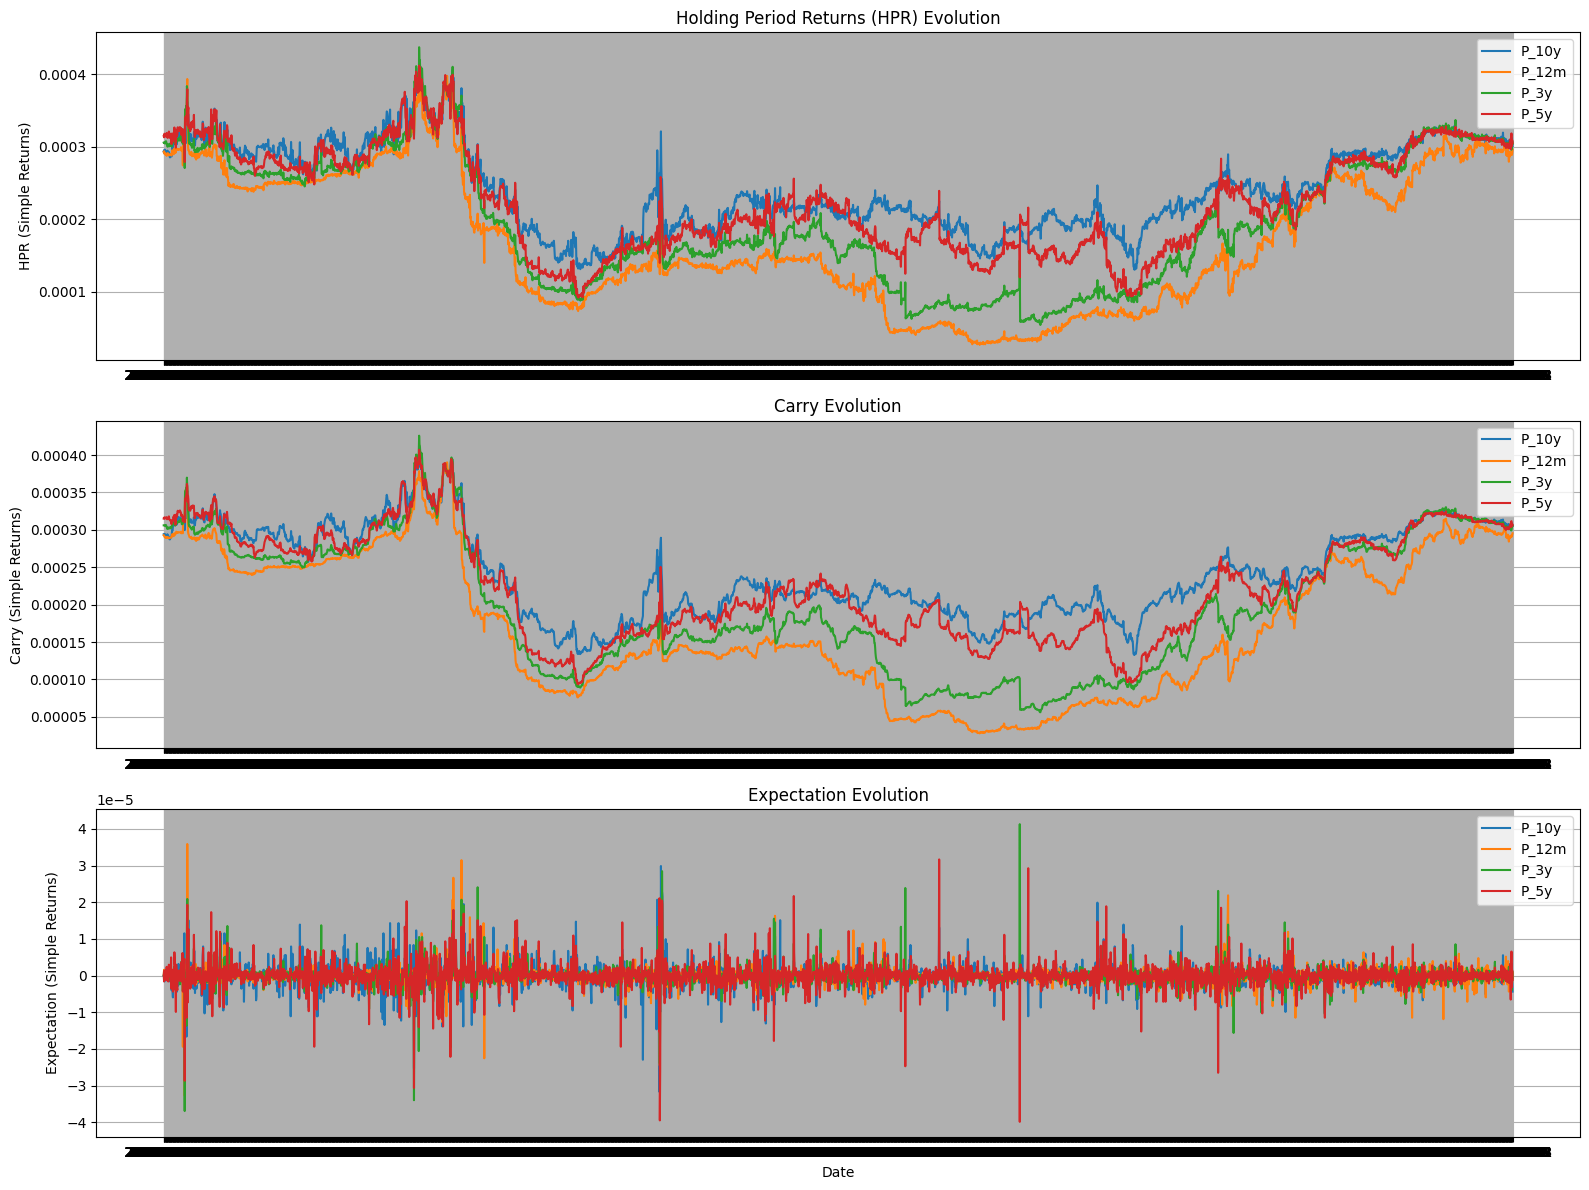

In [82]:
# Set figure size
plt.figure(figsize=(16, 12))

# 1️⃣ Plot HPR evolution
plt.subplot(3, 1, 1)
for col in combined_df.columns.levels[0]:
    plt.plot(combined_df.index, combined_df[(col, 'HPR')], label=col)
plt.title("Holding Period Returns (HPR) Evolution")
plt.ylabel("HPR (Simple Returns)")
plt.legend()
plt.grid(True)

# 2️⃣ Plot Carry evolution
plt.subplot(3, 1, 2)
for col in combined_df.columns.levels[0]:
    plt.plot(combined_df.index, combined_df[(col, 'Carry')], label=col)
plt.title("Carry Evolution")
plt.ylabel("Carry (Simple Returns)")
plt.legend()
plt.grid(True)

# 3️⃣ Plot Expectation evolution
plt.subplot(3, 1, 3)
for col in combined_df.columns.levels[0]:
    plt.plot(combined_df.index, combined_df[(col, 'Expectation')], label=col)
plt.title("Expectation Evolution")
plt.ylabel("Expectation (Simple Returns)")
plt.legend()
plt.grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

## References

The methodology and theoretical background are based on:

> Cochrane, J. H. (2011). *Asset Pricing* (Revised Edition). Princeton University Press.

Yield data used in this article are provided by:

> Banca Națională a României (National Bank of Romania). [https://www.bnr.ro](https://www.bnr.ro)
